In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
milestones = pd.read_csv('data/nycMilestones.csv')
# milestones.shape

# # https://data.cityofnewyork.us/resource/s7yh-frbm

milestones["orig_start_date"] = pd.to_datetime(milestones['orig_start_date'])
milestones["orig_end_date"] = pd.to_datetime(milestones['orig_end_date'])
milestones["task_start_date"] = pd.to_datetime(milestones['task_start_date'])
milestones["task_end_date"] = pd.to_datetime(milestones['task_end_date'])



## (milestones['task_start_date'] - milestones['orig_start_date']) / np.timedelta64(1, 'M')\
projectSteps = pd.DataFrame()
projectSteps[["project_id","managing_agency","boro","step","task"]] = milestones[["project_id","managing_agcy","boro","seq_number","task_description"]]

## milestones[milestones['task_start_date'] < milestones['orig_start_date']].head()
projectSteps["starting_delta"]= ((milestones.task_start_date - milestones.orig_start_date)/np.timedelta64(1, 'M'))
projectSteps["ending_delta"]= ((milestones.task_end_date - milestones.orig_end_date)/np.timedelta64(1, 'M'))

""" Negative starting and ending deltas mean the task was started earlier than scheduled!!! """

projectSteps["starting_delta"] = projectSteps["starting_delta"].astype(int)
projectSteps["ending_delta"] = projectSteps["ending_delta"].astype(int)

# projectSteps.to_csv('data/projectSteps.csv')


In [ ]:
# """ milestones columns to get rid of"""

# milestones = milestones.drop(columns=['pub_date','managing_agcy_cd'], axis=1)
# # milestones.to_csv('data/milestones.csv', date_format='%Y-%m-%d',index=False)

In [8]:
# dateFormat = '%Y-%m-%d'
# m2 = pd.read_csv('data/milestones2.csv', parse_dates=["orig_start_date"], date_parser=lambda x: pd.to_datetime(x, format=dateFormat))

In [11]:
m2.dtypes

pub_date                     int64
boro                        object
managing_agcy_cd             int64
managing_agcy               object
project_id                  object
project_descr               object
seq_number                   int64
task_description            object
orig_start_date     datetime64[ns]
orig_end_date               object
task_start_date             object
task_end_date               object
dtype: object

In [4]:
# numProjects = projectSteps["project_id"].nunique()
# numProjects
projectSteps

,project_id,managing_agency,boro,orig_start,actual_start,step,task,starting_delta,ending_delta
0,F204BGEAR,FIRE DEPARTMENT,CITYWIDE,2022-06-01,2022-06-01,1,CONSTRUCTION,0,0
1,F204BGEAR,FIRE DEPARTMENT,CITYWIDE,2023-06-01,2023-06-01,2,"PUNCHLIST COMPLETE, JOB CLOSED",0,0
2,FALUMP2,DEPARTMENT OF TRANSPORTATION,CITYWIDE,2016-06-01,2020-06-01,1,DEVELOP SCOPE,48,48
3,FALUMP2,DEPARTMENT OF TRANSPORTATION,CITYWIDE,2017-06-01,2021-06-01,2,DESIGN START,48,48
4,FALUMP2,DEPARTMENT OF TRANSPORTATION,CITYWIDE,2019-06-01,2023-06-01,3,CONSTRUCTION START,48,48
...,...,...,...,...,...,...,...,...,...
59307,SOLARPQL2,DEPT OF CITYWIDE ADMIN SERVS,BRONX,2020-07-01,2020-07-01,2,BID AWARD AND REGISTER CONTRCT,0,0
59308,SOLARPQL2,DEPT OF CITYWIDE ADMIN SERVS,BRONX,2020-08-01,2020-08-01,3,CONSTRUCTION TO 50%,0,0
59309,SOLARPQL2,DEPT OF CITYWIDE ADMIN SERVS,BRONX,2021-02-01,2021-02-01,4,CONSTRUCTION TO 75%,0,0
59310,SOLARPQL2,DEPT OF CITYWIDE ADMIN SERVS,BRONX,2021-05-01,2021-05-01,5,SUBSTANTIAL COMPLETION,0,0


# Q1 - Are Projects *Actually* Delayed?

In [16]:
projectStarts = projectSteps.groupby('project_id').agg({'step': 'min', 'starting_delta': 'first'}).reset_index()[['project_id','starting_delta']]

projectStarts['startStatus'] = np.select(
    [
        (projectStarts['starting_delta'] < 0),    # Condition for "early"
        (projectStarts['starting_delta'] > 0)     # Condition for "late"
    ],
    [
        'Early',
        'Late'
    ],
    default='On Time'  # Default value if none of the conditions are met
)

projectFinishes = projectSteps.groupby('project_id').agg({'step': 'max', 'ending_delta': 'first'}).reset_index()[['project_id','ending_delta']]

projectFinishes['endStatus'] = np.select(
                                    [
                                        (projectFinishes['ending_delta'] < 0),    # Condition for "early"
                                        (projectFinishes['ending_delta'] > 0)     # Condition for "late"
                                    ],
                                    [
                                        'Early',
                                        'Late'
                                    ],
                                    default='On Time'  # Default value if none of the conditions are met
                                )

# projectDeltas = pd.DataFrame()

# projectDeltas[['Project ID','Start Status']]=projectStarts[['project_id','startStatus']]

# projectDeltas['End Status']=projectFinishes['endStatus']

# deltasHeatMapDF = projectDeltas.groupby(['Start Status','End Status']).size().unstack()
# deltasHeatMapDF = deltasHeatMapDF.reindex(columns=["Early","On Time","Late"],index=["Early","On Time","Late"]).T

# deltasHeatMapDF.to_csv('data/deltasHeatMapDF.csv')

In [14]:
projectSteps.dtypes

project_id         object
managing_agency    object
boro               object
step                int64
task               object
starting_delta      int64
ending_delta        int64
dtype: object

In [17]:
projectDeltas = pd.DataFrame()

projectDeltas[['Project ID','Start Status']]=projectStarts[['project_id','startStatus']]

projectDeltas['End Status']=projectFinishes['endStatus']

deltasHeatMapDF = projectDeltas.groupby(['Start Status','End Status']).size().unstack()
deltasHeatMapDF = deltasHeatMapDF.reindex(columns=["Early","On Time","Late"],index=["Early","On Time","Late"]).T

deltasHeatMapDF.to_csv('data/deltasHeatMapDF.csv',index=True, header=True)

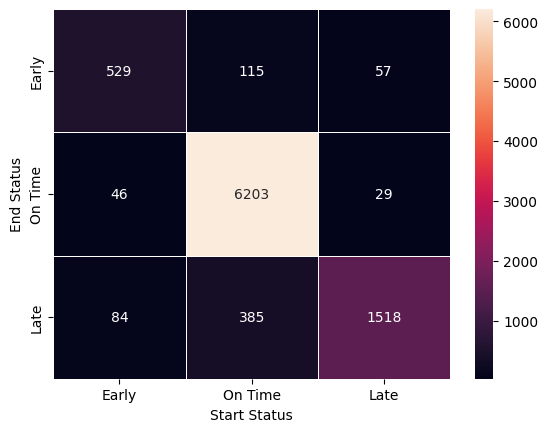

In [18]:
sns.heatmap(deltasHeatMapDF,
            annot=True,
            fmt="d",
            linewidths=.5);

## Box plots and Showing Skewed Data

In [ ]:
# # make box and whisker plots for projectStarts and projectFinishes where they weren't started or finished on time
# sns.boxplot(x="startStatus", y="starting_delta", data=projectStarts[projectStarts['startStatus'] != 'On Time'])
# sns.boxplot(x="endStatus", y="ending_delta", data=projectFinishes[projectFinishes['ending_delta'] != 0])


""" how to hangle skeweness of the data? 
    - if we convert to log scale then negative values will be undefined
        -> try doing an np.select to convert the negative values to positive, then take the log, then convert back to negative

        OR just get rid of the negative values since I really only care about the delayed projects
"""


projectStarts['logStartDelta'] = np.log(projectStarts['starting_delta'])
projectFinishes['logFinishDelta'] = np.log(projectFinishes['ending_delta'])

# logStartDeltas = np.log(projectStarts[projectStarts['starting_delta'] != 0]['starting_delta'])
# logFinishDeltas = np.log(projectFinishes[projectFinishes['ending_delta'] != 0]['ending_delta'])
# sns.displot(logStartDeltas, kde=True);
# sns.displot(logFinishDeltas, kde=True);


# sns.violinplot(x="startStatus", y="logStartDelta", data=projectStarts[projectStarts['startStatus'] != 'On Time'])
# sns.displot(projectStarts[projectStarts['startStatus'] != 'On Time']['starting_delta'], bins=20, kde=False, rug=True);

## Q1 Answer: Kind of
-> 25.2% of projects were late (2170/8970 )  
-> 94.7% of projects that were started late were finished late (1672/1765)  
-> 67.2% of projects were completed on time (6032/8970)

Plots
- side by side boxplots of time deltas by start and end on time, early, and late
- [ x ] heat map of where time deltas are
- 

#Q2 - How much do these projects cost?
- Capital Project Detail Dollars [link](https://data.cityofnewyork.us/City-Government/Capital-Project-Detail-Data-Dollars/wa2y-rh4b)

filter the dollars data by projects that are completed 
- add buckets for months? 
- 


# Q2 - Budget

In [29]:
projectSteps.columns

Index(['project_id', 'managing_agency', 'boro', 'orig_start', 'actual_start',
       'step', 'task', 'starting_delta', 'ending_delta'],
      dtype='object')

In [19]:
budget = pd.read_csv('data/budget.csv') # 72437 rows, 9 columns

# There are more projects in the projectSteps dataframe than in the budget dataframe
budget.groupby("project_id").nunique() # 8578 projects
projectSteps.groupby("project_id").nunique()  # 8966 projects

# merge budget and projectSteps on project_id (inner join)
costs = budget[['project_id','boro','managing_agcy','orig_bud_amt','city_plan_total','noncity_plan_total']]\
    .merge(projectSteps[['project_id','starting_delta','ending_delta']], on='project_id', how='inner')

In [33]:
costs['project_id'].nunique() # 8578 projects

8578

In [20]:
projectCosts = costs.groupby('project_id').agg({'boro':'first',
                                 'managing_agcy': 'first',
                                 'orig_bud_amt': 'first', 
                                 'city_plan_total': 'max', 
                                 'noncity_plan_total': 'sum',
                                 'starting_delta': 'first',
                                 'ending_delta': 'first'}).reset_index()

projectCosts['total_cost']= projectCosts['city_plan_total'] + projectCosts['noncity_plan_total']
projectCosts['cost_delta']= projectCosts['total_cost'] - projectCosts['orig_bud_amt']
projectCosts['costStatus'] = np.select([
                                    (projectCosts['cost_delta'] < 0),    # Condition for "Under Budget"
                                    (projectCosts['cost_delta'] > 0)     # Condition for "Over Budget"
                                ],
                                [
                                    'Under Budget',
                                    'Over Budget'
                                ],
                                default='On Target'  # Default value if none of the conditions is met
                            )   
projectCosts = projectCosts.merge(projectStarts[['project_id','startStatus']], 
                                    on='project_id', 
                                    how='inner')        \
                .merge(projectFinishes[['project_id','endStatus']], 
                                    on='project_id', 
                                    how='inner')
projectCosts['city_pct'] = projectCosts['city_plan_total'] / projectCosts['total_cost']
projectCosts['noncity_pct'] = projectCosts['noncity_plan_total'] / projectCosts['total_cost']
projectCosts['majority_funder'] = np.select([
                                    (projectCosts['city_pct'] <= .5)   # Condition for "Non-City"
                                ],
                                [
                                    'non_city'
                                ],
                                default='city'  # Default value if none of the conditions are met
                            )  
projectCosts["budget_usage"]=np.select([
                            ( projectCosts['costStatus'] == "On Target"),  # Condition for a non 0 budget
                            (projectCosts['orig_bud_amt'] == 0)
                            ],
                            [
                                1.0,
                                (projectCosts['cost_delta']/1) 
                            ],
                            default= (projectCosts['cost_delta']/projectCosts['orig_bud_amt'])   # Default value if none of the conditions are met
                        )   

# projectCosts.to_csv('data/projectCosts.csv')

In [ ]:
# projectCosts['managing_agcy'].value_counts()
projectCosts.columns

In [21]:

costStatusHeatMapDF = projectCosts.groupby(['costStatus','endStatus']).size().unstack()

costStatusHeatMapDF  = costStatusHeatMapDF.reindex(columns=["Late","On Time","Early"],index=["Under Budget","On Target","Over Budget"]).T

costStatusHeatMapDF.to_csv('data/costStatusHeatMapDF.csv', index=True, header=True)

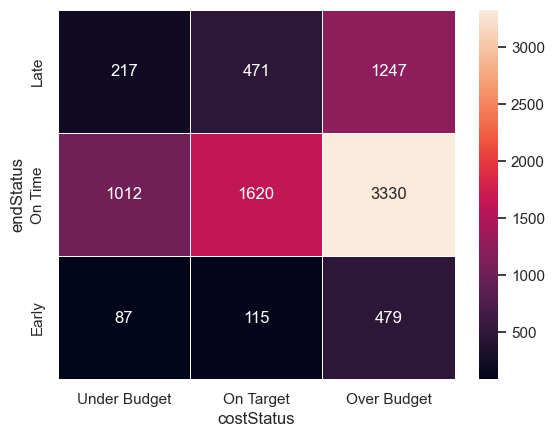

In [97]:
sns.heatmap(costStatusHeatMapDF,
            annot=True,
            fmt="d",
            linewidths=.5);


### Budget Status by Borough

<AxesSubplot: xlabel='boro', ylabel='count'>

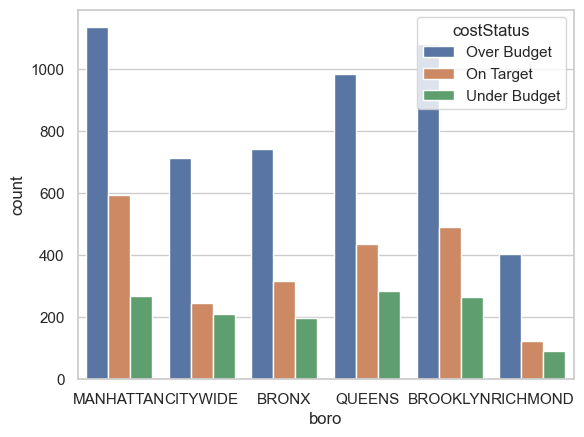

In [116]:
# make a bar plot that shows the number of projects that were over/under budget by boro
sns.countplot(x="boro", hue="costStatus", data=projectCosts);


"""Make it customizable by boro"""
# borough = 'BROOKLYN'

# filteredBoro = projectCosts[projectCosts['boro'] == borough]
# sns.countplot(x="costStatus", data=filteredBoro, order=["Under Budget","On Target","Over Budget"])

In [ ]:
# sns.displot(projectCosts[projectCosts['costStatus'] == 'Over Budget']['cost_delta'], bins=5, kde=False);


sns.kdeplot(projectCosts[projectCosts['costStatus'] == 'Over Budget']['cost_delta'], fill=True,cumulative=True);
# sns.kdeplot(projectCosts['cost_delta'], fill=True,cumulative=True);
# plt.xlim(-1e6, 1e6)

<AxesSubplot: xlabel='costStatus', ylabel='count'>

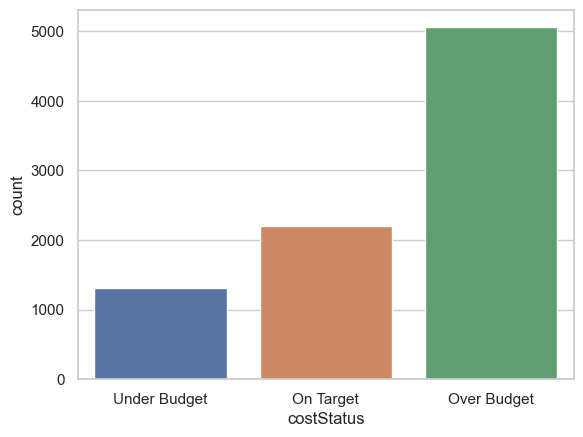

In [89]:
# make a bar plot of the number of projects that were over budget, on budget, and under budget
sns.countplot(x="costStatus",
              data=projectCosts,
              order=["Under Budget","On Target","Over Budget"])

## Avg Project Task Delay by Managing Agency

<AxesSubplot: xlabel='cost_delta', ylabel='managing_agcy'>

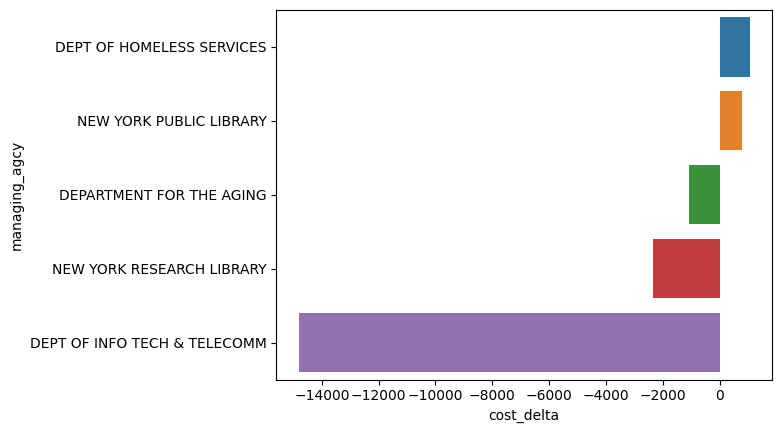

In [16]:
# what is the average cost delta for projects by managing agnecy?
agencyBudgets = projectCosts.groupby('managing_agcy')[['managing_agcy','cost_delta']] \
    .agg({ 'cost_delta': 'mean'}) \
    .astype({'cost_delta': 'int64'}) \
    .sort_values('cost_delta', ascending=False).reset_index()


# plot the top 5 agencies with the highest average cost delta
# sns.barplot(y="managing_agcy",
#             x="cost_delta",
#             data=agencyBudgets.head(),
#             order=agencyBudgets['managing_agcy'].head())


sns.barplot(y="managing_agcy",
            x="cost_delta",
            data=agencyBudgets.tail(),
            order=agencyBudgets['managing_agcy'].tail())

## Who paid for late projects?

In [42]:
""" kdeplots for budget usage by majority funder """
cleanProjectCosts = projectCosts[projectCosts['orig_bud_amt'] != 0]

# # make a kdepolt of the budget usage with one density for each majority funder
# sns.kdeplot(data=cleanProjectCosts[cleanProjectCosts['majority_funder'] == 'city']['budget_usage'], label="City", cumulative=True)



,project_id,boro,managing_agcy,orig_bud_amt,city_plan_total,noncity_plan_total,starting_delta,ending_delta,total_cost,cost_delta,costStatus,startStatus,endStatus,city_pct,noncity_pct,majority_funder,budget_usage
36,12201903,MANHATTAN,HEALTH AND HOSPITALS CORP,56,42.00,0.0,12,9,42.00,-14.00,Under Budget,Late,Late,1.0,0.0,city,-0.250000
47,13200571,MANHATTAN,HEALTH AND HOSPITALS CORP,3765,2914.00,0.0,0,0,2914.00,-851.00,Under Budget,On Time,On Time,1.0,0.0,city,-0.226029
48,13200573,MANHATTAN,HEALTH AND HOSPITALS CORP,3500,1500.00,0.0,0,0,1500.00,-2000.00,Under Budget,On Time,On Time,1.0,0.0,city,-0.571429
49,13200601,MANHATTAN,HEALTH AND HOSPITALS CORP,945,444.46,0.0,6,-6,444.46,-500.54,Under Budget,Late,Early,1.0,0.0,city,-0.529672
52,13201401,MANHATTAN,HEALTH AND HOSPITALS CORP,3261,3253.00,0.0,0,0,3253.00,-8.00,Under Budget,On Time,On Time,1.0,0.0,city,-0.002453
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8535,WILLETURA,QUEENS,DEPT OF SMALL BUSINESS SERVICES,93950,70525.00,0.0,0,0,70525.00,-23425.00,Under Budget,On Time,On Time,1.0,0.0,city,-0.249335
8543,WM-EMRNGY,CITYWIDE,DEPT ENVIRONMENTAL PROTECTION,217238,129005.00,0.0,0,0,129005.00,-88233.00,Under Budget,On Time,On Time,1.0,0.0,city,-0.406158
8561,YC027-008,QUEENS,CITY UNIVERSITY,3698,199.00,0.0,0,0,199.00,-3499.00,Under Budget,On Time,On Time,1.0,0.0,city,-0.946187
8563,YC034-010,QUEENS,CITY UNIVERSITY,1500,1499.00,0.0,0,0,1499.00,-1.00,Under Budget,On Time,On Time,1.0,0.0,city,-0.000667


## Old Code?

/var/folders/3n/g3gstzkx6tvgblfrrfq2mjl80000gn/T/ipykernel_9365/4192607676.py:10: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  small.groupby('managing_agency').mean().plot(kind='barh');


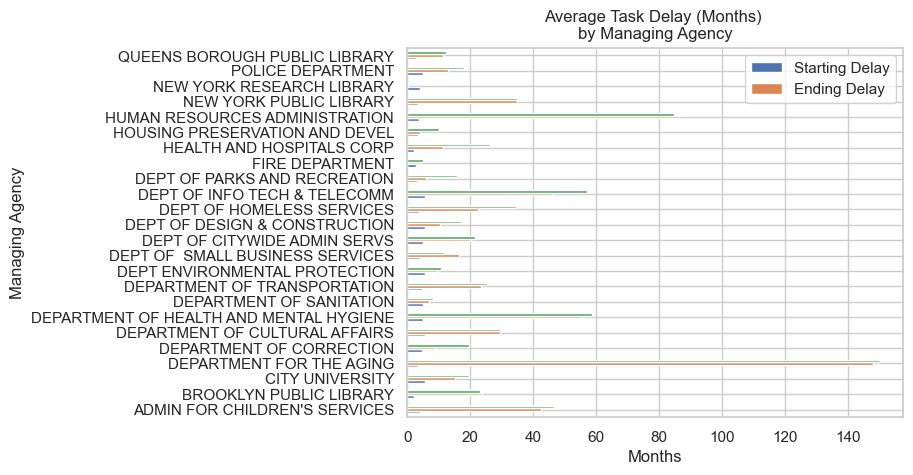

In [119]:
# # Vertical bar
# projectSteps.groupby('managing_agency').mean().plot(kind='bar');
# plt.title('Average Project Delay (Months) \nby Managing Agency');
# plt.ylabel('Months');
# plt.xlabel('Managing Agency');
# plt.xticks(rotation=45,ha='right');
# plt.legend(['Starting Delay','Ending Delay'],loc='upper left', bbox_to_anchor=(-0.5, 1));

# Horizontal bar
projectSteps.groupby('managing_agency').mean().plot(kind='barh');
plt.title('Average Task Delay (Months) \nby Managing Agency');
plt.ylabel('Managing Agency');
plt.xlabel('Months');
plt.legend(['Starting Delay','Ending Delay'],loc='upper right');
plt.savefig('plots/avg_delay_by_agency.png');

## Top 5 Projects (Late and Early)

In [ ]:
projectSteps[#( projectSteps['step'] == 1 ) &
        (projectSteps['task'] == 'CONSTRUCTION START') &
        ( projectSteps['starting_delay_m'] > 0 )
      ].sort_values(by='starting_delay_m',ascending=False).head(10)